# 1. Objetivo

La idea del proycto es realizar una clasificación de imágenes en tres clases -> Frutas, Vegetales y Paquetes.

#### data set reference
```
  title={A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels},
  author={Klasson, Marcus and Zhang, Cheng and Kjellstr{\"o}m, Hedvig},
  booktitle={IEEE Winter Conference on Applications of Computer Vision (WACV)},
  year={2019}
```

## Un puntapie de inicio

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
!pip install keras.applications
from keras_applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

     |████████████████████████████████| 50 kB 3.1 MB/s 


#### Vamos a crear algunas funciones útiles

In [2]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Descarga y Armado del dataset

In [3]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6556, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6556 (delta 0), reused 1 (delta 0), pack-reused 6553
Receiving objects: 100% (6556/6556), 116.25 MiB | 29.66 MiB/s, done.
Resolving deltas: 100% (313/313), done.
Checking out files: 100% (5717/5717), done.


In [4]:
## fijamos los paths
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

In [5]:
!ls GroceryStoreDataset/dataset/train/Fruit

Apple	 Kiwi	Mango	   Orange	  Peach      Plum	     Satsumas
Avocado  Lemon	Melon	   Papaya	  Pear	     Pomegranate
Banana	 Lime	Nectarine  Passion-Fruit  Pineapple  Red-Grapefruit


In [6]:
!ls GroceryStoreDataset/dataset/train/Vegetables

Asparagus	    Cabbage   Garlic  Onion   Red-Beet
Aubergine	    Carrots   Ginger  Pepper  Tomato
Brown-Cap-Mushroom  Cucumber  Leek    Potato  Zucchini


In [7]:
!ls GroceryStoreDataset/dataset/train/Packages

Juice  Oatghurt  Sour-Cream  Soyghurt  Yoghurt
Milk   Oat-Milk  Sour-Milk   Soy-Milk


## Preprocesamiento inicial de los datos
Creamos algunos preprocesamientos sin ningun variación ni aumento de los datos. Este es el comienzo :)

In [8]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [9]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


Vemos algunas imagenes

In [10]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [11]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_path,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 2640 files belonging to 3 classes.


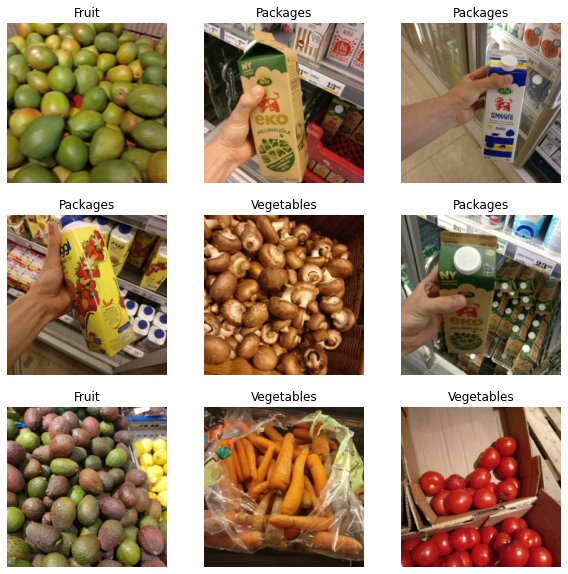

In [12]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# 3. Crear un Modelo base Convolusional

In [13]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 96)                37850208  
                                                                 
 dense_1 (Dense)             (None, 3)                 291       
                                                                 
Total params: 37,851,395
Trainable params: 37,851,395
Non-trainable params: 0
____________________________________________

In [14]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=10,
      validation_data=validation_batches,
      validation_steps=steps_valid)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/10
82/82 [==============================] - 28s 196ms/step - loss: 485.3407 - acc: 0.4822 - val_loss: 141.7545 - val_acc: 0.5642
Epoch 2/10
82/82 [==============================] - 11s 137ms/step - loss: 151.3408 - acc: 0.5989 - val_loss: 110.6375 - val_acc: 0.6216
Epoch 3/10
82/82 [==============================] - 11s 137ms/step - loss: 100.2014 - acc: 0.6508 - val_loss: 69.5121 - val_acc: 0.6115
Epoch 4/10
82/82 [==============================] - 11s 137ms/step - loss: 60.6923 - acc: 0.6902 - val_loss: 74.2557 - val_acc: 0.6284
Epoch 5/10
82/82 [==============================] - 11s 136ms/step - loss: 41.9161 - acc: 0.7326 - val_loss: 41.8110 - val_acc: 0.6182
Epoch 6/10
82/82 [==============================] - 11s 138ms/step - loss: 20.9287 - acc: 0.7856 - val_loss: 28.6891 - val_acc: 0.6149
Epoch 7/10
82/82 [==============================] - 11s 137ms/step - loss: 8.9470 - acc: 0.8564 - val_loss: 19.1925 - val_acc: 0.5946
Epoch 8/10
82/82 [==============================] -

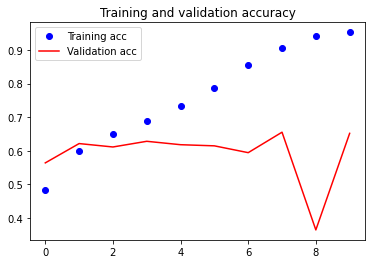

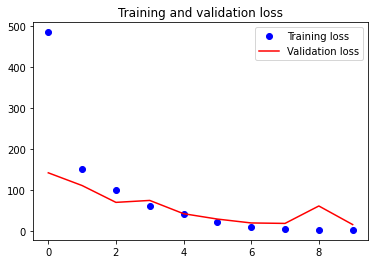

In [15]:
import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

##Complejización del Modelo

In [16]:
model = models.Sequential()

#Capa Convolucional con 32 neuronas
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
#Capa Pooling
model.add(layers.MaxPooling2D((2, 2)))

#Capa Convolucional con 64 neuronas
model.add(layers.Conv2D(64, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
#Capa Pooling
model.add(layers.MaxPooling2D((2, 2)))

#Capa Convolucional con 128 neuronas
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
#Capa Pooling
model.add(layers.MaxPooling2D((2, 2)))

#Capa Convolucional con 128 neuronas
model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
#Capa Pooling
model.add(layers.MaxPooling2D((2, 2)))

#Capa de Aplanamiento
model.add(layers.Flatten())

#Capa Densa con 512 neuronas
model.add(layers.Dense(512, activation='relu'))

#Capa Dropout
model.add(layers.Dropout(0.5))

#Capa de Clasificación con la categorías
model.add(layers.Dense(3, activation='softmax'))

#Compiling
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#Estructura del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 26, 26, 128)     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=15,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/15
82/82 [==============================] - 15s 159ms/step - loss: 4.9787 - acc: 0.5985 - val_loss: 1.0501 - val_acc: 0.5541
Epoch 2/15
82/82 [==============================] - 13s 151ms/step - loss: 0.6153 - acc: 0.7424 - val_loss: 1.0772 - val_acc: 0.6216
Epoch 3/15
82/82 [==============================] - 12s 150ms/step - loss: 0.4810 - acc: 0.8057 - val_loss: 1.2042 - val_acc: 0.5338
Epoch 4/15
82/82 [==============================] - 12s 151ms/step - loss: 0.3685 - acc: 0.8557 - val_loss: 1.1401 - val_acc: 0.6385
Epoch 5/15
82/82 [==============================] - 12s 150ms/step - loss: 0.2807 - acc: 0.8943 - val_loss: 1.1614 - val_acc: 0.6318
Epoch 6/15
82/82 [==============================] - 14s 165ms/step - loss: 0.2818 - acc: 0.9265 - val_loss: 1.1464 - val_acc: 0.6115
Epoch 7/15
82/82 [==============================] - 19s 227ms/step - loss: 0.1503 - acc: 0.9443 - val_loss: 1.3112 - val_acc: 0.6284
Epoch 8/15
82/82 [==============================] - 13s 151ms/step - 

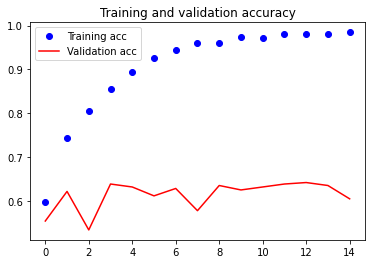

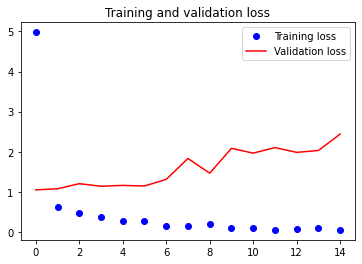

In [18]:
acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Aumento de datos

Para el mismo modelo que armamos arriba (es decir, una vez que definan uno, se quedan con ese), hagamos un poco de aumento de cantidad de datos. Es una buena forma de tener más datos y prevenir también el overfitting. 

Se puede aumentar los datos con los generadores de entrenamiento. Se recomienta usar reescalamiento, recorte, zoom y espejado horizontal.

* reescalar los inputs de 0,255 a 0,1
* aplicar el rango de recorte (shear_range) para aplicar cortes aleatorios
* aplicar rango de zoom (zoom_range) para aplicar zoom aleatorio a las imágenes
* poner true el espejado horizontal (horizontal_flip) para obtener imágenes espejo horizontales)

Recuerden usar las mismas funciones de activación y optimización, para poder probar el mismo modelo.

Siempre recuerden plotear validación contra training para ver si hay overfitting.

Recuerden que hay que reescalar el test también, porque el modelo aprendió a utilizar los datos escalados

un buen lugar para consultar sobre Image Data Generator (la herramienta para aumentar los datos)
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [50]:
#### Les dejo algo de código para que vayan empezando

train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=8,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.


In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['acc'])

fit_generator_2 = model.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=steps_valid,
        callbacks=[reduce_lr])


Epoch 1/15
52/52 [==============================] - 42s 754ms/step - loss: 0.2628 - acc: 0.8898 - val_loss: 0.4988 - val_acc: 0.8142 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 39s 740ms/step - loss: 0.2479 - acc: 0.8955 - val_loss: 0.5901 - val_acc: 0.7635 - lr: 0.0010
Epoch 3/15
53/52 [==============================] - ETA: 0s - loss: 0.2080 - acc: 0.9098
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 [==============================] - 39s 733ms/step - loss: 0.2080 - acc: 0.9098 - val_loss: 0.8161 - val_acc: 0.7804 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 39s 732ms/step - loss: 0.1817 - acc: 0.9269 - val_loss: 0.6433 - val_acc: 0.7939 - lr: 5.0000e-04
Epoch 5/15
53/52 [==============================] - ETA: 0s - loss: 0.1761 - acc: 0.9265
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
52/52 [==============================] - 39s 739ms/step - loss: 0.1761 - acc: 0.9265 

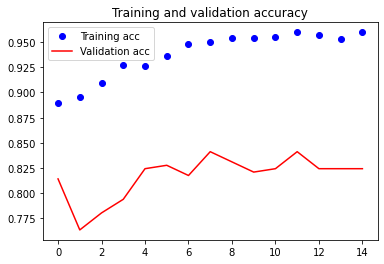

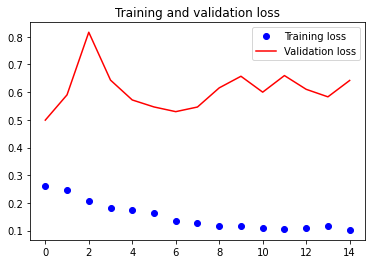

In [26]:
acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Red Preentrenada y Fine-Tuning

Probar con VGG16, recortando las últimas capas de la red para hacer fine tuning. El que se anime, puede probar ResNet también que es una red con una arquitectura bastante más compleja!

Recuerden que tienen que setear cuáles serán las capas a entrenar.
Les dejo documentación al respecto! :)

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [29]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input

In [ ]:
#### Recuerden que aquí, cuando ya estén medio estables con los resultados, pueden empezar a jugar con los optimizadores y también realizar el aumento de imágenes para el modelo con vgg o resnet :)
#### SUERTE Y CUALQUIER COSA  ME PREGUNTAN!

In [31]:
# Eliminanos la capa superior de vgg16 y quedandonos con la estructura de la red
vgg = VGG16 (include_top=False,weights="imagenet", input_tensor=Input(shape=(224,224,3)))
vgg.summary()
#Freezamos las capas que no vamos a reentrenar
for layers in vgg.layers:
    layers.trainable= False
model= Flatten()(vgg.output)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [38]:
#Agregamos las capas de clasificación
red_vgg = tf.keras.models.Sequential([ vgg,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
red_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_13 (Dense)            (None, 256)               6422784   
                                                                 
 dense_14 (Dense)            (None, 3)                 771       
                                                                 
Total params: 21,138,243
Trainable params: 6,423,555
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
red_vgg.compile(loss="categorical_crossentropy",
        optimizer= optimizers.Adam(),
        metrics=["acc"]
        )

fit_generator_vgg = red_vgg.fit(
                  train_generator,
                  steps_per_epoch=steps_train,
                  epochs=15,
                  validation_data=validation_generator,
                  validation_steps=steps_valid,
                  callbacks=[reduce_lr])




Epoch 1/15
52/52 [==============================] - 55s 996ms/step - loss: 0.3340 - acc: 0.8636 - val_loss: 0.4468 - val_acc: 0.8514 - lr: 0.0010
Epoch 2/15
52/52 [==============================] - 48s 908ms/step - loss: 0.2238 - acc: 0.9106 - val_loss: 0.3189 - val_acc: 0.8818 - lr: 0.0010
Epoch 3/15
52/52 [==============================] - 48s 901ms/step - loss: 0.1934 - acc: 0.9186 - val_loss: 0.2570 - val_acc: 0.8953 - lr: 0.0010
Epoch 4/15
52/52 [==============================] - 51s 966ms/step - loss: 0.2071 - acc: 0.9117 - val_loss: 0.3997 - val_acc: 0.8581 - lr: 0.0010
Epoch 5/15
53/52 [==============================] - ETA: 0s - loss: 0.1635 - acc: 0.9348
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 [==============================] - 63s 1s/step - loss: 0.1635 - acc: 0.9348 - val_loss: 0.2899 - val_acc: 0.8818 - lr: 0.0010
Epoch 6/15
52/52 [==============================] - 49s 920ms/step - loss: 0.1417 - acc: 0.9436 - val_loss: 0.2859 

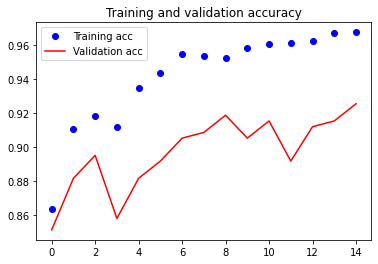

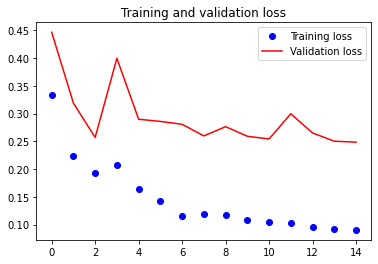

In [52]:
acc = fit_generator_vgg.history['acc']
val_acc = fit_generator_vgg.history['val_acc']
loss = fit_generator_vgg.history['loss']
val_loss = fit_generator_vgg.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()